In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
DATA_DIR = r"F:\Dataset RP\CXR8\images\images"
CSV_FILE = r"F:\Dataset RP\CXR8\Data_Entry_2017_v2020.csv"

df = pd.read_csv(CSV_FILE)
df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [6]:
# Get unique disease labels
all_labels = df['Finding Labels'].unique()

# Split multiple labels into a list
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# Convert labels into a one-hot encoding format
for label in all_labels:
    df[label] = df['Finding Labels'].apply(lambda x: 1 if label in x else 0)

# Select required columns
labels = all_labels.tolist()
df = df[['Image Index'] + labels]


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5376\385817364.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = df['Finding Labels'].apply(lambda x: 1 if label in x else 0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5376\385817364.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = df['Finding Labels'].apply(lambda x: 1 if label in x else 0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5376\385817364.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Image data generators for normalization and augmentation
image_size = (320, 320)

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, directory=DATA_DIR, x_col="Image Index", y_col=labels,
    target_size=image_size, batch_size=32, class_mode="raw")

val_generator = val_datagen.flow_from_dataframe(
    val_df, directory=DATA_DIR, x_col="Image Index", y_col=labels,
    target_size=image_size, batch_size=32, class_mode="raw")


Found 89696 validated image filenames.
Found 22424 validated image filenames.


In [8]:
# Load pre-trained DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(len(labels), activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 326, 326,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 160, 160,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 160, 160,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 160, 160,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 162, 162,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 80, 80,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 80, 80,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 80, 80,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 80, 80,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 80, 80,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 80, 80,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 80, 80,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 80, 80,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 80, 80,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 80, 80,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 80, 80,    │     12,288 │ conv2_block2_0_r

 Total params: 7,276,548 (27.76 MB)

 Trainable params: 239,044 (933.77 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [9]:
import os
import tarfile

DATA_DIR = r"F:\Dataset RP\CXR8\images"  # Update this if needed

# Extract all .tar.gz files
for file in os.listdir(DATA_DIR):
    if file.endswith(".tar.gz"):
        file_path = os.path.join(DATA_DIR, file)
        print(f"Extracting {file_path}...")
        with tarfile.open(file_path, "r:gz") as tar:
            tar.extractall(DATA_DIR)  # Extract into the same directory
        print(f"Extracted: {file}")

print("✅ Extraction complete!")


Extracting F:\Dataset RP\CXR8\images\images_001.tar.gz...
Extracted: images_001.tar.gz
Extracting F:\Dataset RP\CXR8\images\images_002.tar.gz...
Extracted: images_002.tar.gz
Extracting F:\Dataset RP\CXR8\images\images_003.tar.gz...
Extracted: images_003.tar.gz
Extracting F:\Dataset RP\CXR8\images\images_004.tar.gz...
Extracted: images_004.tar.gz
Extracting F:\Dataset RP\CXR8\images\images_005.tar.gz...
Extracted: images_005.tar.gz
Extracting F:\Dataset RP\CXR8\images\images_006.tar.gz...
Extracted: images_006.tar.gz
Extracting F:\Dataset RP\CXR8\images\images_007.tar.gz...
Extracted: images_007.tar.gz
Extracting F:\Dataset RP\CXR8\images\images_008.tar.gz...
Extracted: images_008.tar.gz
Extracting F:\Dataset RP\CXR8\images\images_009.tar.gz...
Extracted: images_009.tar.gz
Extracting F:\Dataset RP\CXR8\images\images_010.tar.gz...
Extracted: images_010.tar.gz
Extracting F:\Dataset RP\CXR8\images\images_011.tar.gz...
Extracted: images_011.tar.gz
Extracting F:\Dataset RP\CXR8\images\images

In [10]:
import os
print(os.listdir(r"F:\Dataset RP\CXR8\images\images")[:10])  # Should list `.png` or `.jpg` files


['00000001_000.png', '00000001_001.png', '00000001_002.png', '00000002_000.png', '00000003_000.png', '00000003_001.png', '00000003_002.png', '00000003_003.png', '00000003_004.png', '00000003_005.png']


In [11]:
image_path = os.path.join(DATA_DIR, train_df.iloc[0]["Image Index"])
print("Checking:", image_path)
print("Exists:", os.path.exists(image_path))

Checking: F:\Dataset RP\CXR8\images\00029763_001.png
Exists: False


In [12]:
history = model.fit(train_generator, epochs=2, validation_data=val_generator)


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 21888s 8s/step - accuracy: 0.5119 - loss: 0.0178 - val_accuracy: 0.5377 - val_loss: 0.0036
Epoch 2/2
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 19065s 7s/step - accuracy: 0.5362 - loss: 0.0036 - val_accuracy: 0.5524 - val_loss: 0.0035


701/701 ━━━━━━━━━━━━━━━━━━━━ 3343s 5s/step - accuracy: 0.5574 - loss: 0.0035
Validation Loss: 0.0035, Validation Accuracy: 0.5524


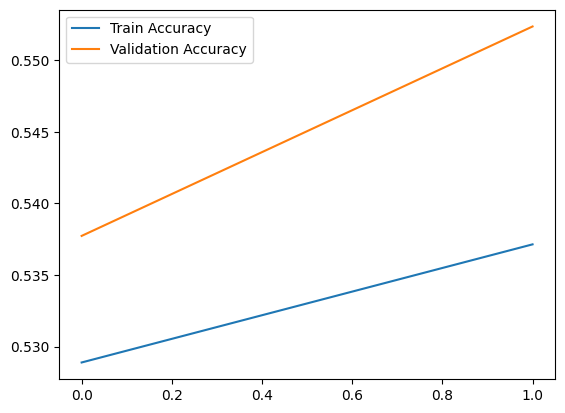

In [13]:
# Evaluate on validation set
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

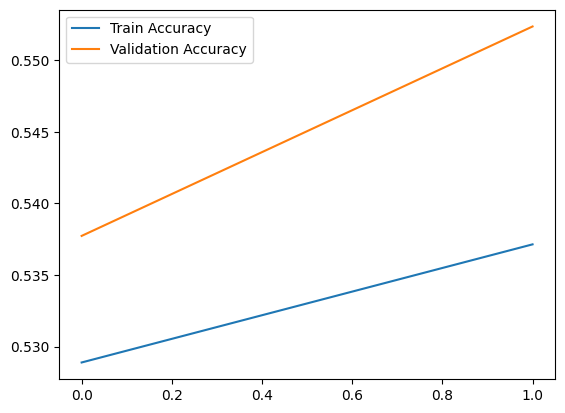

In [14]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Generate predictions on validation set
y_pred_prob = model.predict(val_generator)

# Step 2: Apply threshold to get binary outputs
y_pred = (y_pred_prob > 0.5).astype(int)

# Step 3: Extract true labels
y_true = val_generator.labels

# Step 4: Get list of class names
class_names = list(all_labels)  # Make sure 'all_labels' is still defined

# Step 5: Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)

print(report)


701/701 ━━━━━━━━━━━━━━━━━━━━ 3243s 5s/step
                                                                                                      precision    recall  f1-score   support

                                                                                        Cardiomegaly       0.00      0.00      0.00       545
                                                                              Cardiomegaly|Emphysema       0.00      0.00      0.00         0
                                                                               Cardiomegaly|Effusion       0.00      0.00      0.00         0
                                                                                          No Finding       0.54      0.71      0.62     12173
                                                                                              Hernia       0.00      0.00      0.00        39
                                                                                 Hernia|Infiltration    

In [16]:
# Save model in HDF5 format
model.save("chest_xray_model.h5")


In [17]:
import pickle

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [18]:
import json

# Save the list of labels (important for consistent predictions)
with open('label_map.json', 'w') as f:
    json.dump(list(all_labels), f)


In [19]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("chest_xray_model.h5")
